<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=18JwHT8YDIJhm1Of7wvk65XdVfWxcg4af' width="200" />
<figcaption></figcaption></center>
</figure>

# ***Resolución de problemas directos e inversos de ecuaciones diferenciales mediante técnicas de deep learning***

**Practicantes:** Fernando Fêtis y Diego Olguín. 

**Supervisor:** Hugo Carrillo.




In [7]:
#@title Instalación e importación de FEniCS

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()

 #   
try:
    import dolfin as dol
    from dolfin import (
        SubDomain, 
        Measure,
        plot,
        SubMesh,
        BoundaryMesh,
        MeshFunction,
        CompiledSubDomain,
        DOLFIN_EPS,
        FiniteElement,
        MixedElement,
        FunctionSpace,
        as_tensor,
        grad,
        dot,
        inner,
        dx,
        ds,
        TrialFunction,
        TestFunction,
        between
    )
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin as dol
    from dolfin import (
        SubDomain, 
        Measure,
        plot,
        SubMesh,
        BoundaryMesh,
        MeshFunction,
        CompiledSubDomain,
        DOLFIN_EPS,
        FiniteElement,
        MixedElement,
        FunctionSpace,
        as_tensor,
        grad,
        dot,
        inner,
        dx,
        ds,
        TrialFunction,
        TestFunction,
        between
    )

from IPython.display import clear_output, display
import dolfin.common.plotting as fenicsplot 

import os, sys, shutil

In [8]:
#@title Instalación e importación de Dolfin Adjoint

import mshr
from collections import OrderedDict

try:
  import dolfin_adjoint as dol_ad
  from dolfin_adjoint import (
      Constant,
      Expression,
      Function,
      interpolate,
      DirichletBC,
      project,
      solve,
      assemble,
      Control,
      ReducedFunctional,
      minimize, 
      Mesh,
      compute_gradient,
      UnitSquareMesh
  )

except ImportError:
  !pip install git+https://bitbucket.org/dolfin-adjoint/pyadjoint.git@master

  import dolfin_adjoint as dol_ad
  from dolfin_adjoint import (
      Constant,
      Expression, 
      Function,
      interpolate,
      DirichletBC,
      project,
      solve,
      assemble,
      Control,
      ReducedFunctional,
      minimize,
      Mesh,
      compute_gradient,
      UnitSquareMesh
  )

In [9]:
#@title Instalación e importación de Moola

try:
  import moola 
except:
  !pip install moola
  import moola

In [10]:
#@title Librerías

from shapely.affinity import affine_transform
from shapely.geometry import Point, Polygon
from shapely.ops import triangulate
from shapely.prepared import prep

import shapely 

In [11]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import random

from time import time
from scipy import stats

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

## Resolución del problema con PINNs

In [13]:
#@title Código de generación de mallas poligonales

class PolygonMesh:

  def __init__(self, vertices):

    P = shapely.Polygon(vertices)

    self.vertices = vertices
    self.geometry = shapely.geometry.polygon.orient(P)
    self.edges = self._get_edges()
    self.normals = {}
    self.samples = {}
    self.interior_subdomains = {}
    self.boundary_subdomains = {}

  def _get_edges(self):
    edges = []
    N_edges = len(self.geometry.boundary.coords)

    for i in range(N_edges-1):
      (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
      edges.append([(x0, y0), (x1, y1)])
    
    return edges

  def add_interior_subdomain(self, subdomain, name=""):
    keys = self.interior_subdomains.keys()
    if name=="":
      name = "int"+str(len(keys)+1)
    elif name=="res":
      name = "int"+str(len(keys)+1)
      print("'res' is not a valid name for subdomain, instead using "+name)

    self.interior_subdomains[name] = subdomain
  

  def add_boundary_subdomain(self, subdomain, name=""):
    keys = self.boundary_subdomains.keys()
    if name=="":
      name = "int"+str(len(keys)+1)
    elif name=="res":
      name = "int"+str(len(keys)+1)
      print("'res' is not a valid name for subdomain, instead using "+name)

    self.boundary_subdomains[name] = subdomain


  def sample_interior(self, k_samples):

    if self.interior_subdomains != {}:
      k = sum(k_samples.values())
      self.samples['interior'] = {}

      i_points = {}

      for key in self.interior_subdomains.keys():
        i_points[key] = []

      i_points['res'] = []

      T = triangulate(self.geometry)
      triangs = [t for t in T if self.geometry.contains(t)]

      areas = []
      transforms = []
      for t in triangs:
          areas.append(t.area)
          (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
          transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])

      for transform in random.choices(transforms, weights=areas, k=k):
          x, y = np.random.random(2)
          if x + y > 1:
            x, y = 1 - x, 1 - y 
            p = Point(x, y)
          else:
            p = Point(x, y)

          t_point = affine_transform(p, transform)
            
          xn, yn = t_point.coords.xy[0][0], t_point.coords.xy[1][0]
          bound = 'res'

          for key in self.interior_subdomains.keys():
            if self.interior_subdomains[key](xn, yn):
              if len(i_points[key]) < k_samples[key]:
                bound = key
              else:
                bound = ''

            if bound != '':
              i_points[bound].append(t_point)

      for key in self.interior_subdomains.keys():
        points = i_points[key]
        torch_points = torch.tensor([p.coords for p in points]).reshape(-1, 2).T
        self.samples['interior'][key] = torch_points

      torch_points = torch.tensor([p.coords for p in i_points['res']]).reshape(-1, 2).T
      self.samples['interior']['res'] = torch_points

    else:
      k = k_samples

      T = triangulate(self.geometry)
      triangs = [t for t in T if self.geometry.contains(t)]

      areas = []
      transforms = []
      points = []
      for t in triangs:
          areas.append(t.area)
          (x0, y0), (x1, y1), (x2, y2), _ = t.exterior.coords
          transforms.append([x1 - x0, x2 - x0, y1 - y0, y2 - y0, x0, y0])
      
      for transform in random.choices(transforms, weights=areas, k=k):
          x, y = np.random.random(2)
          if x + y > 1:
              p = Point(1 - x, 1 - y)
          else:
              p = Point(x, y)

          points.append(affine_transform(p, transform))

      torch_points = torch.tensor([p.coords for p in points]).reshape(-1, 2).T

      self.samples['interior'] = {'res': torch_points}

    return self.samples['interior']


  def sample_boundary(self, k_samples):

    if self.boundary_subdomains != {}:
      k = sum(k_samples.values())

      b_points, lengths, edges = {}, [], []
      N_edges = len(self.geometry.boundary.coords)

      for key in self.boundary_subdomains.keys():
        b_points[key] = []

      b_points['res'] = []

      for i in range(N_edges-1):
        (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
        lengths.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))
        edges.append([(x0, y0), (x1, y1)])

      for edge in random.choices(edges, weights=lengths, k=k):
        lambd = np.random.random()
        (x0, y0), (x1, y1) = edge
        xn, yn = (1-lambd)*x0 + lambd*x1, (1-lambd)*y0 + lambd*y1

        bound = 'res'

        for key in self.boundary_subdomains.keys():
          if self.boundary_subdomains[key](xn, yn):
            if len(b_points[key]) < k_samples[key]:
              bound = key
            else:
              bound = ''

        if bound != '':
          b_points[bound].append(Point(xn, yn))

      self.samples['boundary'] = {}

      for key in self.boundary_subdomains.keys():

        torch_points = torch.tensor([p.coords for p in b_points[key]]).reshape(-1, 2).T
        self.samples['boundary'][key] = torch_points
        self.normals[key] = self._normal_vector(torch_points[0], torch_points[1])

      torch_points = torch.tensor([p.coords for p in b_points['res']]).reshape(-1, 2).T
      self.samples['boundary']['res'] = torch_points
      self.normals['res'] = self._normal_vector(torch_points[0], torch_points[1])
      
    else:
      k = k_samples 

      b_points, lengths, edges = [], [], []
      N_edges = len(self.geometry.boundary.coords)

      for i in range(N_edges-1):
        (x0, y0), (x1, y1) = self.geometry.boundary.coords[i], self.geometry.boundary.coords[i+1]
        lengths.append(np.sqrt((x1-x0)**2 + (y1-y0)**2))
        edges.append([(x0, y0), (x1, y1)])

      for edge in random.choices(edges, weights=lengths, k=k):
        lambd = np.random.random()
        (x0, y0), (x1, y1) = edge
        b_points.append(Point((1-lambd)*x0 + lambd*x1, (1-lambd)*y0 + lambd*y1))

      torch_points = torch.tensor([p.coords for p in b_points]).reshape(-1, 2).T

      self.samples['boundary'] = {'res': torch_points}

      self.normals['res'] = self._normal_vector(torch_points[0], torch_points[1])

    return self.samples['boundary']


  def plot_samples(self):

    if self.samples == {}:
      print("No samples to plot. Generate samples first.")

    else:
      if 'interior' in self.samples.keys():
        for key in self.samples['interior'].keys():
          plt.plot(*self.samples['interior'][key], '.', label=key)

      if 'boundary' in self.samples.keys():
        for key in self.samples['boundary'].keys():
          plt.plot(*self.samples['boundary'][key], '.', label=key)

      plt.legend()
         


  def plot(self):
    x = np.array(self.geometry.exterior.coords.xy[0])
    y = np.array(self.geometry.exterior.coords.xy[1])

    plt.fill(x,y, facecolor='lightblue', edgecolor='blue')
    plt.show()


  def _normal_vector(self, x, y, tol=1e-3):
    E = self.edges
    N = len(E)

    normals = torch.zeros((len(x), 2))

    for i in range(len(x)):

      con_edge = torch.zeros(2)
      xi, yi = x[i], y[i]

      for j in range(N):
        edge = shapely.LineString(E[j])
        buf = edge.buffer(tol)
        if buf.contains(Point(xi.item(), yi.item())):
          con_edge = torch.tensor(E[j][1]) - torch.tensor(E[j][0])

      if torch.dot(con_edge, con_edge)==0:
        print("Point not in boundary or Point it's a vertex")
        n = torch.zeros(2)

      elif con_edge[0].item() == 0:
        n = torch.tensor([1., 0.])
        n *= torch.sign(n[0]*con_edge[1] - n[1]*con_edge[0])

      else:
        e1 = torch.tensor([0., 1.])
        n = e1 - torch.dot(e1, con_edge)/torch.dot(con_edge, con_edge) * con_edge 
        n *= torch.sign(n[0]*con_edge[1] - n[1]*con_edge[0])/torch.linalg.norm(n)

      normals[i] = n

    return normals.reshape(2, len(x))


  def grid(self, step):

    latmin, lonmin, latmax, lonmax = self.geometry.bounds
    prep_polygon = prep(self.geometry)

    points = []
    for lat in np.arange(latmin, latmax, step):
        for lon in np.arange(lonmin, lonmax, step):
            points.append(Point((round(lat,4), round(lon,4))))

    valid_points = []
    valid_points.extend(filter(prep_polygon.contains, points))

    grid_coords = torch.tensor([p.coords for p in valid_points]).reshape(-1, 2)

    x, y = grid_coords.T

    return x, y

In [14]:
#@title Generación red neuronal y función de derivación

class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide, use_dropout = False, p=0.01):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(2 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 1)
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(p=p)

    def forward(self, x, t):
        input = torch.cat([x, t], axis=1)
        
        if self.use_dropout:
          for layer in self.inner_layers:
              input = nn.Tanh()(layer(input))
              input = self.dropout(input)

        else:
          for layer in self.inner_layers:
              input = nn.Tanh()(layer(input))

        input = self.last_layer(input)
        
        return input

def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

### Dominio a utilizar

En lo que sigue del problema, trabajaremos en un dominio $\Omega$ que será un rombo como se muestra a continuación.

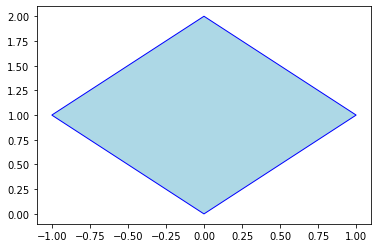

In [15]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

domain.plot()

### Primer problema

El primer problema a abordar es 
    \begin{align*}
        -\Delta u & = 0, \quad  \Omega \\
        u & = x+y,  \quad \partial \Omega 
    \end{align*}
que tiene como solución analítica $u(x,y) = x+y$, con $\Omega$ el rombo mostrado antes.

In [16]:
def solution(x, y):
  return x+y

def known(x, y, net):
  u = net(x, y)
  return u - solution(x, y)

In [17]:
cos, pi = torch.cos, torch.pi
sin = torch.sin

def pde(x, y, u):
    u = net(x, y)
    u_x = derivative(u, x)
    u_y = derivative(u, y)
    u_xx = derivative(u_x, x)
    u_yy = derivative(u_y, y)
    
    return u_xx + u_yy

El objetivo es darle al problema solo una porción de solución conocida en el dominio y en el resto informar de la física a la red a entrenar, esto es, anadirlo a la pérdida a minimizar. Formalmente esto es: suponemos se tienen $\{ (x_i, \, y_i, \, u_i) \}_{i=1}^N$ puntos de solución conocida y $\{ (x_j, \, y_j) \}_{j=1}^M$ donde se conoce la física del problema, es decir, la ecuación que satisface. Luego, el objetivo es minimizar la siguiente pérdida $\mathcal{L}$:
\begin{equation*}
    \mathcal{L}_{\text{data}} = \sum_{i=1}^N (u_\theta(x_i, y_i) - u_i)^2 , \, \quad \mathcal{L}_{\text{physics}} = \sum_{j=1}^M (\Delta u_\theta(x_j, y_j) + f(x_j, y_j))^2
\end{equation*}
\begin{equation*}
     \mathcal{L} = \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{physics}} 
\end{equation*}
Donde $u_\theta$ es la red neuronal que aproxima a la solución del problema. Se probará con los subdominios contenidos en el rombo correspondientes a $x > 0.75$, $x > 0.5$, $x>0$ y otro subdominio que corresponderá a un cuadrado pequeño centrado en $(1,1)$.

#### $x > 0.75$

In [18]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return x > 0.75

domain.add_interior_subdomain(subdomain, 'right')

In [19]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary = 500
samples_collocation = {'res': 500,
                       'right': 200}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['right'][0].unsqueeze(1).requires_grad_(), samp_c['right'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
    
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00000041
Epoch  20 - loss: 0.00000041


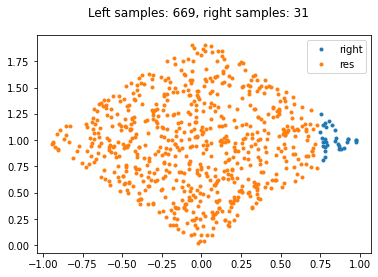

In [20]:
right_samples = len(domain.samples['interior']['right'][0])
left_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Left samples: {left_samples}, right samples: {right_samples}")
domain.plot_samples()

plt.savefig("UCPSamples1.pdf")

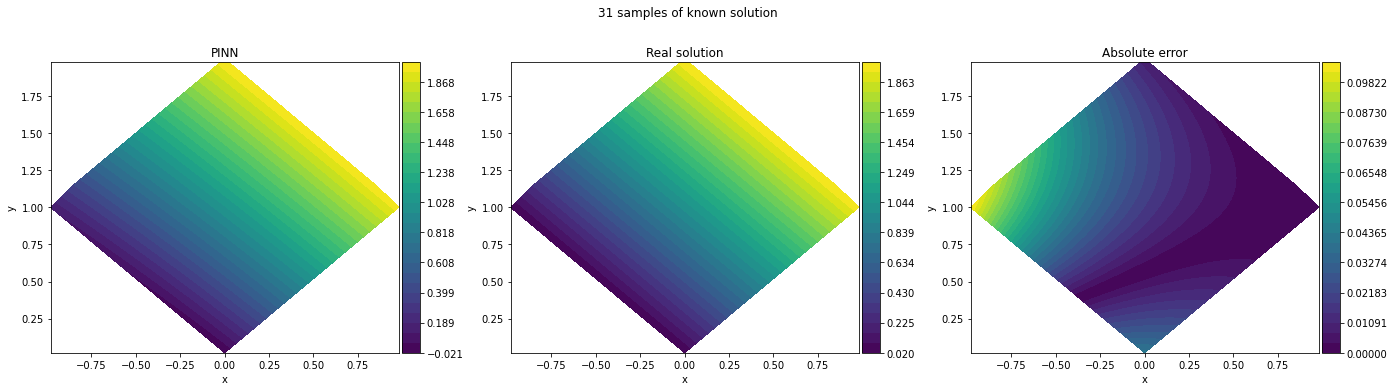

In [21]:
right_samples = len(domain.samples['interior']['right'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(right_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots1.pdf")

plt.show()

#### $x > 0.5$

In [22]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return x > 0.5

domain.add_interior_subdomain(subdomain, 'right')

In [23]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary = 500
samples_collocation = {'res': 400,
                       'right': 300}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['right'][0].unsqueeze(1).requires_grad_(), samp_c['right'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
    
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00000176
Epoch  20 - loss: 0.00000018


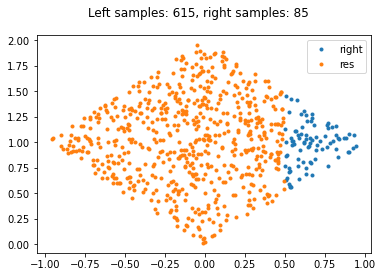

In [24]:
right_samples = len(domain.samples['interior']['right'][0])
left_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Left samples: {left_samples}, right samples: {right_samples}")
domain.plot_samples()
plt.savefig("UCPSamples2.pdf")

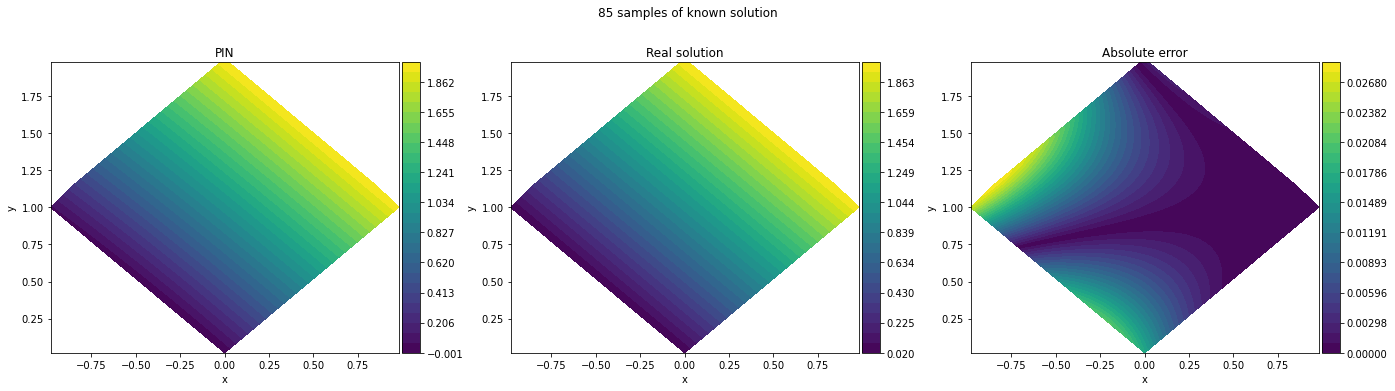

In [25]:
right_samples = len(domain.samples['interior']['right'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(right_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PIN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots2.pdf")

plt.show()

#### $x > 0$

In [26]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return x >= 0

domain.add_interior_subdomain(subdomain, 'right')

In [27]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary = 500
samples_collocation = {'res': 500,
                       'right': 200}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['right'][0].unsqueeze(1).requires_grad_(), samp_c['right'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
    
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00000125
Epoch  20 - loss: 0.00000124


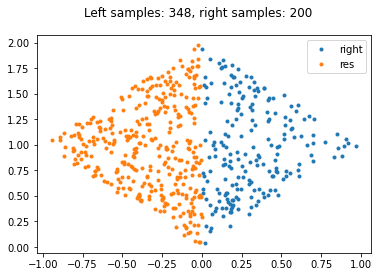

In [28]:
right_samples = len(domain.samples['interior']['right'][0])
left_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Left samples: {left_samples}, right samples: {right_samples}")
domain.plot_samples()
plt.savefig("UCPSamples3.pdf")

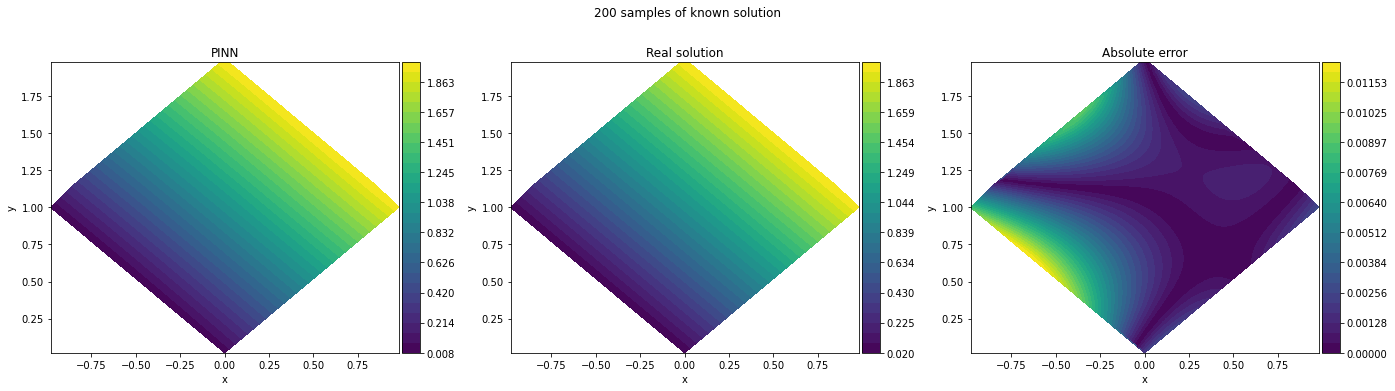

In [29]:
right_samples = len(domain.samples['interior']['right'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(right_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")
plt.savefig("UCPPlots3.pdf")

plt.show()

#### Subdominio cuadrado

In [30]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return (x > -0.2)*(x < 0.2)*(y > 0.8)*(y < 1.2)

domain.add_interior_subdomain(subdomain, 'center')

In [31]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary = 500
samples_collocation = {'res': 350,
                       'center': 350}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['center'][0].unsqueeze(1).requires_grad_(), samp_c['center'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
  
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00000182
Epoch  20 - loss: 0.00000182


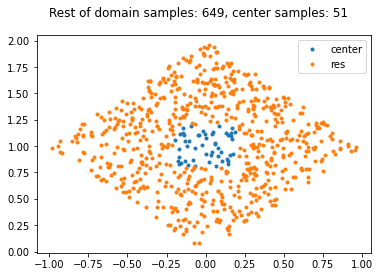

In [32]:
center_samples = len(domain.samples['interior']['center'][0])
res_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Rest of domain samples: {res_samples}, center samples: {center_samples}")
domain.plot_samples()
plt.savefig("UCPSamples4.pdf")

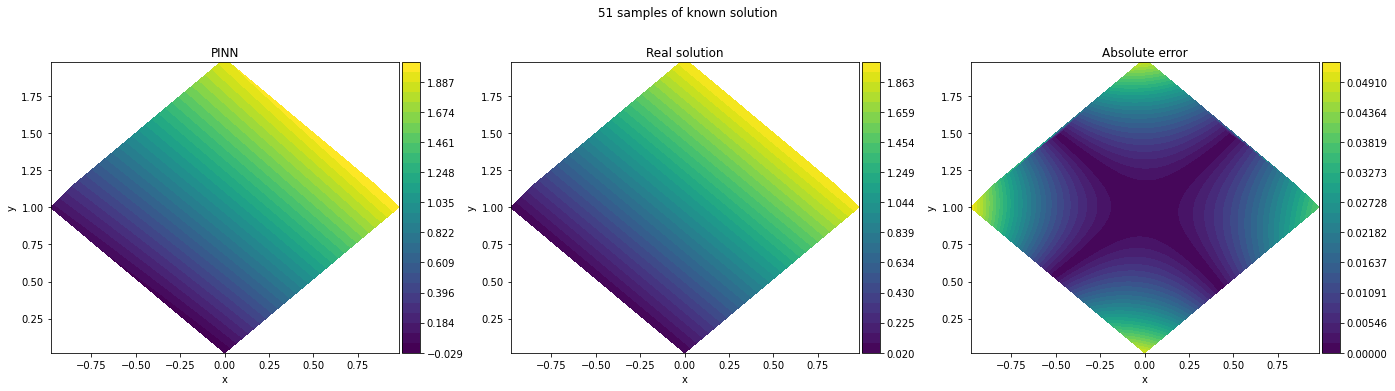

In [33]:
center_samples = len(domain.samples['interior']['center'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(center_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels, vmin=u_sol.min().item(), vmax=u_sol.max().item())
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots4.pdf")

plt.show()

### Segundo problema

El segundo problema a abordar es 
    \begin{align*}
        -\Delta u & = (x^2 + y^2) \cos(xy), \quad  \Omega \\
        u & = \cos (xy),  \quad \partial \Omega 
    \end{align*}
que tiene como solución analítica $u(x,y) = \cos (xy)$, con $\Omega$ el rombo mostrado antes.

In [34]:
def solution(x, y):
  return torch.cos(x*y)

def known(x, y, net):
  u = net(x, y)
  return u - solution(x, y)

In [35]:
cos, pi = torch.cos, torch.pi
sin = torch.sin

def pde(x, y, u):
    u = net(x, y)
    u_x = derivative(u, x)
    u_y = derivative(u, y)
    u_xx = derivative(u_x, x)
    u_yy = derivative(u_y, y)
    
    return u_xx + u_yy + (x**2 + y**2)*cos(x*y)

Se hace lo análogo a lo anterior, con los mismos subdominios, salvo que ahora el subdominio cuadrado será más pequeño.

#### $x > 0.75$

In [36]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return x > 0.75

domain.add_interior_subdomain(subdomain, 'right')

In [37]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary = 500
samples_collocation = {'res': 500,
                       'right': 200}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['right'][0].unsqueeze(1).requires_grad_(), samp_c['right'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
    
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00001589
Epoch  20 - loss: 0.00000990


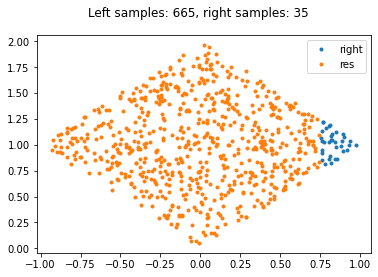

In [38]:
right_samples = len(domain.samples['interior']['right'][0])
left_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Left samples: {left_samples}, right samples: {right_samples}")
domain.plot_samples()
plt.savefig("UCPSamples5.pdf")

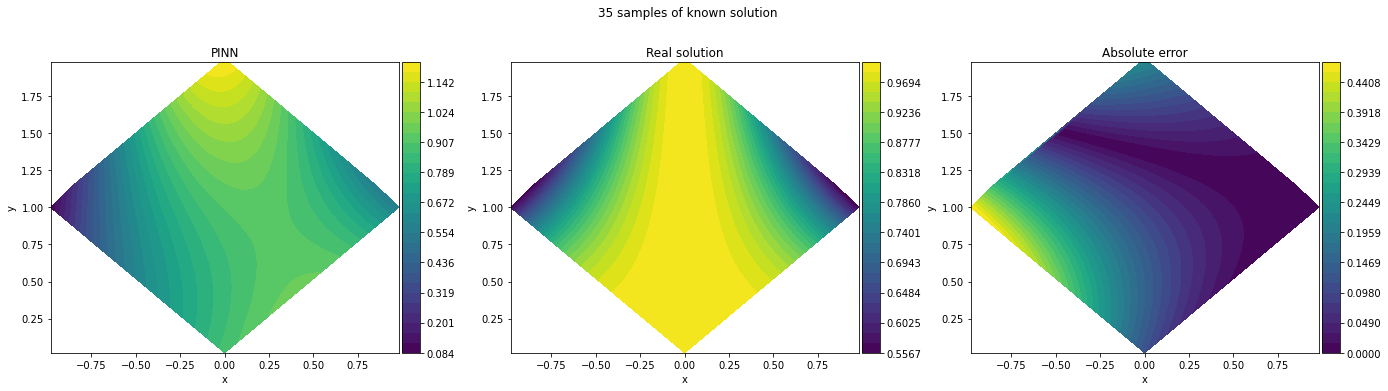

In [39]:
right_samples = len(domain.samples['interior']['right'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(right_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots5.pdf")

plt.show()

#### $x > 0.5$

In [40]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return x > 0.5

domain.add_interior_subdomain(subdomain, 'right')

In [41]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary = 500
samples_collocation = {'res': 400,
                       'right': 300}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['right'][0].unsqueeze(1).requires_grad_(), samp_c['right'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
    
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00002098
Epoch  20 - loss: 0.00000318


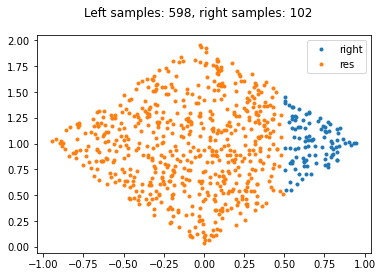

In [42]:
right_samples = len(domain.samples['interior']['right'][0])
left_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Left samples: {left_samples}, right samples: {right_samples}")
domain.plot_samples()
plt.savefig("UCPSamples6.pdf")

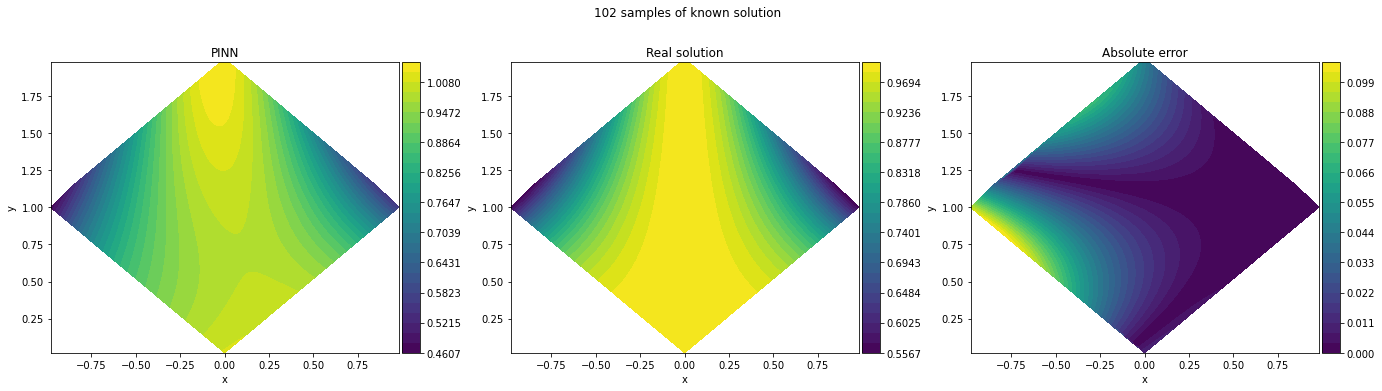

In [43]:
right_samples = len(domain.samples['interior']['right'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(right_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots6.pdf")

plt.show()

#### $x > 0$

In [44]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return x >= 0

domain.add_interior_subdomain(subdomain, 'right')

In [45]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary, samples_collocation = 500, 500
samples_collocation = {'res': 350,
                       'right': 350}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['right'][0].unsqueeze(1).requires_grad_(), samp_c['right'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
    
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00004455
Epoch  20 - loss: 0.00000656


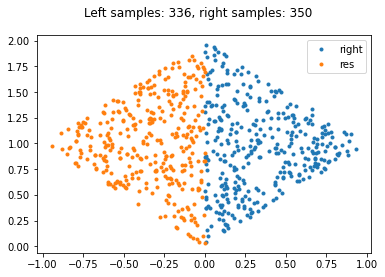

In [46]:
right_samples = len(domain.samples['interior']['right'][0])
left_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Left samples: {left_samples}, right samples: {right_samples}")
domain.plot_samples()
plt.savefig("UCPSamples7.pdf")

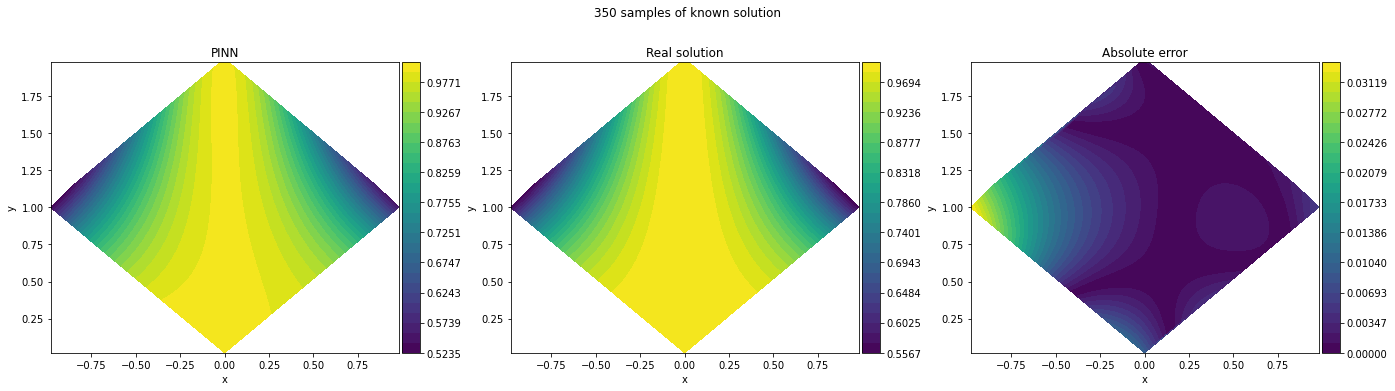

In [47]:
right_samples = len(domain.samples['interior']['right'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(right_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots7.pdf")

plt.show()

#### Subdominio cuadrado

In [48]:
vertices = torch.tensor([(0., 0.), (1., 1.), (0., 2.), (-1., 1.)])
domain = PolygonMesh(vertices)

def subdomain(x,y):
  return (x > -0.1)*(x < 0.1)*(y > 0.9)*(y < 1.1)

domain.add_interior_subdomain(subdomain, 'center')

In [49]:
net = NeuralNetwork(n_layers=2, wide=100, use_dropout=False, p=0.0)
optimizer = optim.LBFGS(net.parameters())

samples_boundary, samples_collocation = 500, 500
samples_collocation = {'res': 350,
                       'center': 350}
epochs = 20

samp_c = domain.sample_interior(samples_collocation)

x_c1, y_c1 = samp_c['center'][0].unsqueeze(1).requires_grad_(), samp_c['center'][1].unsqueeze(1).requires_grad_()
x_c2, y_c2 = samp_c['res'][0].unsqueeze(1).requires_grad_(), samp_c['res'][1].unsqueeze(1).requires_grad_()

target_collocation = torch.zeros(len(x_c2), 1)
target_known = torch.zeros(len(x_c1), 1)

def calc_loss():
  
    pde_collocation = pde(x_c2, y_c2, net)
    loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)

    pred_known = known(x_c1, y_c1, net)
    loss_known = nn.MSELoss()(target_known, pred_known)

    return loss_collocation + loss_known

def closure():
    optimizer.zero_grad()
    loss = calc_loss()
    loss.backward()
    return loss

net.train()

print("Training")

print()

try:
  for epoch in range(1, epochs + 1):
      optimizer.step(closure)
      if epoch % 10 == 0:
          print(f'Epoch {epoch:3} - loss: {calc_loss():.8f}')
except KeyboardInterrupt:
  print()
  print("Interrupting training")
  pass

Training

Epoch  10 - loss: 0.00003866
Epoch  20 - loss: 0.00000441


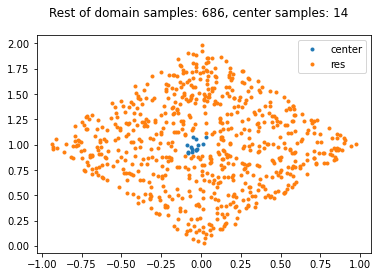

In [50]:
center_samples = len(domain.samples['interior']['center'][0])
res_samples = len(domain.samples['interior']['res'][0])
plt.suptitle(f"Rest of domain samples: {res_samples}, center samples: {center_samples}")
domain.plot_samples()
plt.savefig("UCPSamples8.pdf")

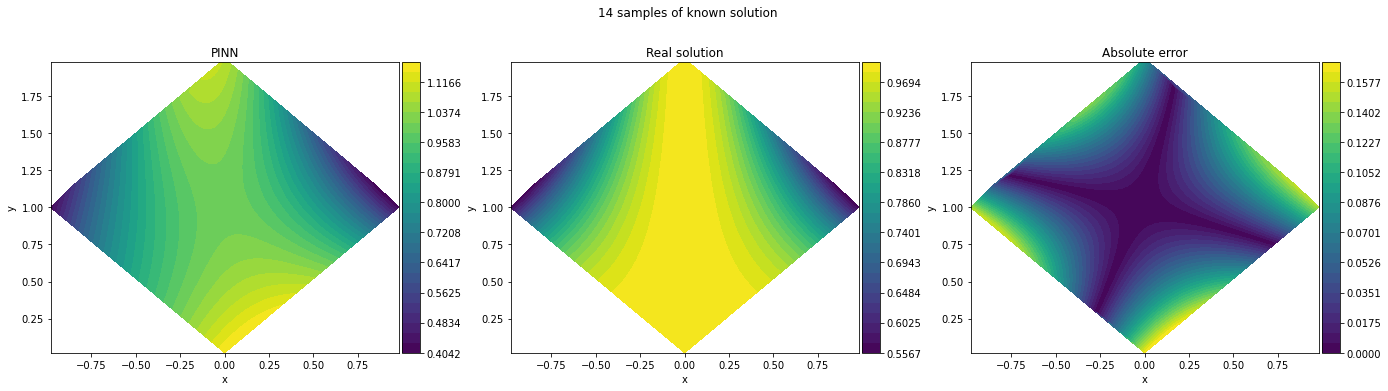

In [51]:
center_samples = len(domain.samples['interior']['center'][0])

x_plot, y_plot = domain.grid(0.02)

x1 = x_plot.reshape(-1, 1)
y1 = y_plot.reshape(-1, 1)

u_pred = net(x1, y1).reshape(-1).detach()

u_sol = solution(x_plot, y_plot)

error = torch.abs(u_sol - u_pred)

fig, ax = plt.subplots(1, 3, figsize=(20,6))
fig.tight_layout(pad=6.0)

plt.suptitle(str(center_samples)+" samples of known solution")

levels = np.linspace(u_pred.min().item(), u_pred.max().item(), 30)
c = ax[0].tricontourf(x_plot, y_plot, u_pred, levels=levels)
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("PINN")

levels = np.linspace(u_sol.min().item(), u_sol.max().item(), 30)
c = ax[1].tricontourf(x_plot, y_plot, u_sol, levels=levels)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Real solution")

levels = np.linspace(error.min().item(), error.max().item(), 30)
c = ax[2].tricontourf(x_plot, y_plot, error, levels=levels)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(c, cax=cax, orientation='vertical')

ax[2].set_xlabel("x")
ax[2].set_ylabel("y")
ax[2].set_title("Absolute error")

plt.savefig("UCPPlots8.pdf")

plt.show()

## Resolución del problema con FEniCS

### Generación de la malla

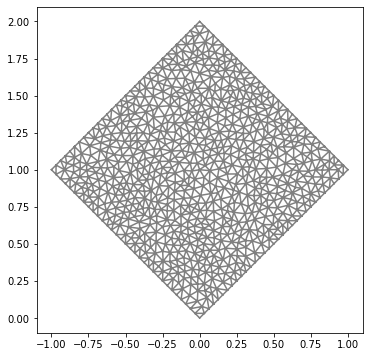

In [52]:
points = [dol.Point(0, 0),
          dol.Point(1, 1),
          dol.Point(0, 2),
          dol.Point(-1, 1)]

p = mshr.Polygon(points)
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 20))

plt.figure(figsize=(8,6))
plot(mesh)
plt.show()

### Generación de la función para medición como solución del problema directo

In [53]:
def PoissonForward(V, W, mesh, f, g):  
  u = TrialFunction(V)
  v = TestFunction(V)

  a = inner(grad(u), grad(v))*dol.dx 
  L = (f * v) * dol.dx
  bc = DirichletBC(V, g, "on_boundary")

  u = Function(V)
  solve(a == L, u, bc)

  return u

### Primer problema

Se resuelve el mismo problema planteado en la sección anterior.

#### $x > 0.75$

In [54]:
V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("0", name='Control', degree=1), W)
g = interpolate(Expression("x[0] + x[1]", degree=1), V)
u = PoissonForward(V, W, mesh, f, g)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0076344 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.197404 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_cd40aaaf5bc0b68be1a587d7bb9a08da6d0820e7

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00538039 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0320871 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_65e75342d5fe3b0ec049a7350e8db1e845e595e3

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_20]'
  Unique elements:           'CG1(?,?), DG0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), DG0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0713003 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4f750817ecc896f3bedcb4ff8c9f3352153b1b38

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00469756 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0491667 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3720490578293ae8ad5feabedc46584f48fda4c4

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00607562 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0130556 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6020ccd6dcfeb87cac710740a2e34c862b3ff865

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0657914 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

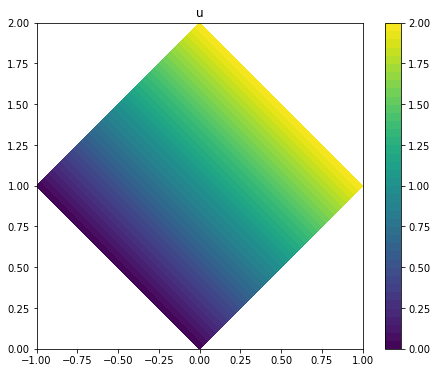

In [55]:
plt.figure(figsize=(8,6))
c = plot(u)
plt.colorbar(c)
plt.title("u")
plt.show()

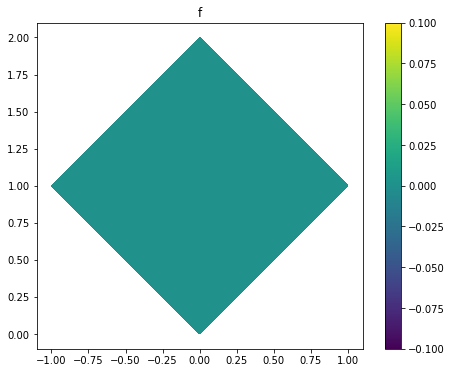

In [56]:
plt.figure(figsize=(8,6))
c = plot(f)
plt.colorbar(c)
plt.title("f")
plt.show()

In [57]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('x[0] > 0.75')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("0", name='Control', degree=1), W)
g = interpolate(Expression("x[0] + x[1]", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_3c2d3bd32175ed03fabe06b1d7385cd0325f6ab4

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[f_77, f_102]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.037816 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_c79f5b91d98357b9617c61084228087eb4aebf65

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00471568 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.018755 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representatio

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_4e9148e5a11011c8abe9f12efc0c13259a9185e5

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00673509 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0171227 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling coordinate_mapping ffc_coordinate_mapping_3033b71026c9233fd179fa3a39cd0150599d984c

INFO:FFC:Compiler stage 1: Analyzing coordinate_mapping(s)
INFO:FFC:-------------------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00583124 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 0 elements
INFO:FFC:  Computing representation of 0 dofmaps
INFO:FFC:  Computing representation of 1 coordinate mappings
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0191119 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:--------------------------------------------------------
INFO

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_8604ff48385b2691a2abb149366f76677ef9a930

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'DG0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), Vector<2 x CG1(?,?)>, CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0261467 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_2b28f7f8fa6e2830cf6fda58151c96fd133c8150

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00384998 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.0177584 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representati

Newton CG method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 200

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_c7a1744611e6d1472ec6a9e5650423d128782aba

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    2
  Coefficients:              '[f_149, f_162]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0539279 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_119545f647cd2d9ded289afc2c1b2cf0c31de709

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_149, f_162]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0334573 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_1bb1201719f8b05ab36b6aaa879106135d9808b2

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0342588 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_d0cdabb1158ad27ecfa8c8bf182bf2e141eda24e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_193]'
  Unique elements:           'DG0(?,?), CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0415814 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:---------

iteration = 0:	objective = 1.3070798539065708e-05:	grad_norm = 4.183085334754008e-05:
TEST: 1.7498202917834054e-09 7.319647601014143e-14
Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_875419017701f6e5f20c11f766c58fe4abcfb739

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_212]'
  Unique elements:           'CG1(?,?), DG0(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), DG0(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.039485 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f92039f08fe8c35f62762f9db57558260ea63102

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 0
INFO:FFC:  quadrature_degree: 0
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0389276 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_f1d9cb9093ee4d28fcc3180ed3da9a49797a0afc

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      0
  Arguments:                 '()'
  Number of coefficients:    3
  Coefficients:              '[f_149, f_162, f_227]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0427132 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_5383e3e830f773177d027bc3065c99b6af0f12bb

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_149, f_162]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0341277 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_0eba68a513c2d2acf69e54df0df3862452242ea5

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 2
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_227]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0288846 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_fea40f74b28c1d9b32332d6b81d0751c04652ee9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_262]'
  Unique elements:           'DG0(?,?), CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'DG0(?,?), CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 1
INFO:FFC:  quadrature_degree: 1
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.035084 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------

cg_iter = 0	curve = 1.1802976974518009e-13	hesstol = 0
TEST: 7.446745944801511e-13 7.319647601014143e-14
cg_iter = 1	curve = 3.393075365261455e-18	hesstol = 0
-g 2.6104948026166202e-05
iteration = 1:	objective = 1.8324525982580325e-08:	grad_norm = 2.5741331232851153e-07:	delta_J = 1.3052474013083128e-05:
TEST: 6.626161336393584e-14 1.705662137624189e-20
cg_iter = 0	curve = 2.8267185462147907e-19	hesstol = 0
TEST: 2.7121041492846127e-14 1.705662137624189e-20
cg_iter = 1	curve = 4.850207679521488e-20	hesstol = 0
TEST: 9.030014973349225e-15 1.705662137624189e-20
cg_iter = 2	curve = 2.914145483345352e-19	hesstol = 0
TEST: 9.070188380759706e-15 1.705662137624189e-20
cg_iter = 3	curve = 4.3005968616247704e-20	hesstol = 0
TEST: 2.4072473206123204e-15 1.705662137624189e-20
cg_iter = 4	curve = 3.0921600122740494e-21	hesstol = 0
TEST: 2.650630283175589e-16 1.705662137624189e-20
cg_iter = 5	curve = 5.521141431766843e-23	hesstol = 0
TEST: 7.89081331394838e-17 1.705662137624189e-20
cg_iter = 6	curv

In [58]:
print(f"Time for x > 0.75: {round(total_time,2)} seconds")

Time for x > 0.75: 22.41 seconds


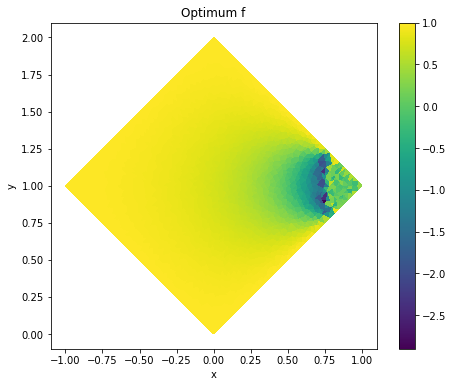

In [59]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

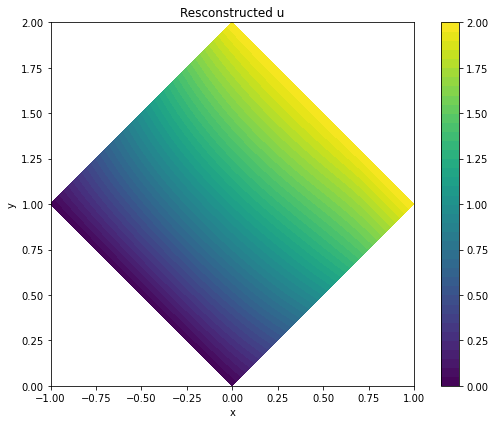

In [60]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS1.pdf")

plt.show()

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_10838f4a19a1efaf207c9b5b51628adb4eaacae9

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      2
  Arguments:                 '(v_0, v_1)'
  Number of coefficients:    0
  Coefficients:              '[]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0318103 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-----------------------------

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_79a873dc83ba46c55df10618e67366176b98a88e

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    2
  Coefficients:              '[f_77, f_7285]'
  Unique elements:           'CG1(?,?), Vector<2 x CG1(?,?)>'
  Unique sub elements:       'CG1(?,?), Vector<2 x CG1(?,?)>'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 2
INFO:FFC:  quadrature_degree: 2
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.0280435 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:----------------------

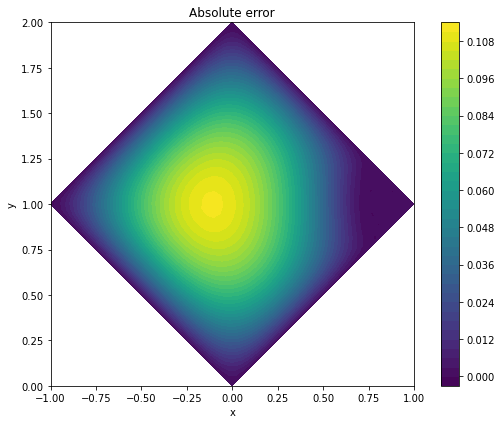

In [61]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError1.pdf")

plt.show()

#### $x > 0.5$

In [62]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('x[0] > 0.5')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("0", name='Control', degree=1), W)
g = interpolate(Expression("x[0] + x[1]", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Newton CG method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 200

iteration = 0:	objective = 0.00037448431104664386:	grad_norm = 0.0008640310368413526:
TEST: 7.465496326251428e-07 6.450420531306331e-10
cg_iter = 0	curve = 7.491906378004137e-10	hesstol = 0
-g 0.0007439179373744543
iteration = 1:	objective = 2.52534235941659e-06:	grad_norm = 1.606442876497257e-05:	delta_J = 0.00037195896868722725:
TEST: 2.580658715448781e-10 4.145680810103256e-15
cg_iter = 0	curve = 1.6962497361288828e-14	hesstol = 0
TEST: 4.570923349669558e-11 4.145680810103256e-15
cg_iter = 1	curve = 2.1209515449368213e-14	hesstol = 0
TEST: 4.938533375594311e-11 4.145680810103256e-15
cg_iter = 2	curve = 3.0317407839087913e-15	hesstol = 0
TEST: 2.022536081380634e-12 4.145680810103256e-15
cg_iter = 3	curve = 4.079904758674773e-17	hesstol = 0
TEST: 3.2904290874452244e-12 4.145680810103256e-15
cg_iter = 4	curve = 2.4057751899081573e-16	hesstol = 0
TEST: 2.66963201935754e-13 4.1456808101

In [63]:
print(f"Time for x > 0.5: {round(total_time,2)} seconds")

Time for x > 0.5: 40.86 seconds


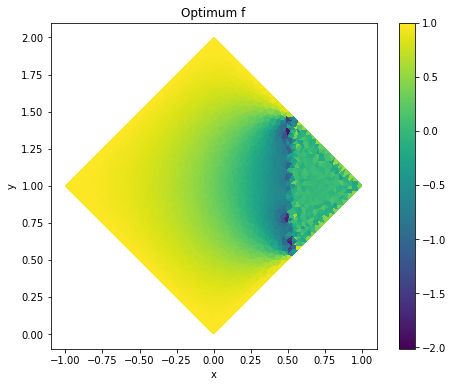

In [64]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

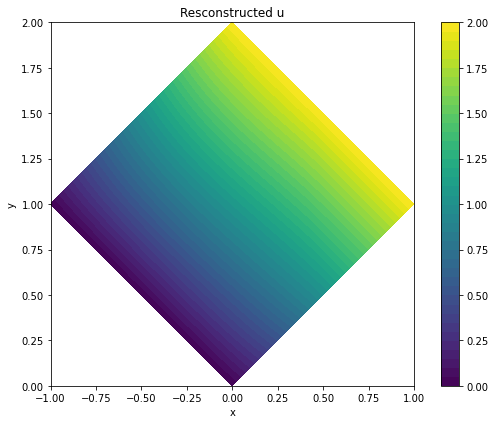

In [65]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS2.pdf")

plt.show()

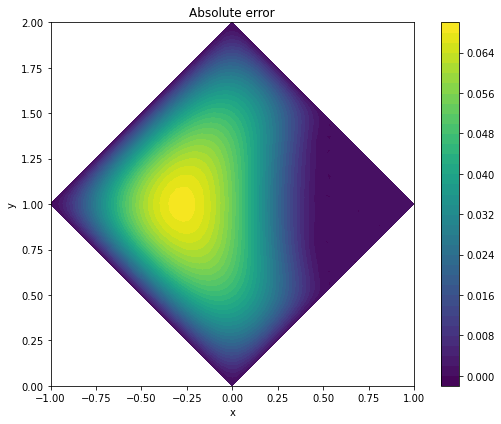

In [66]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError2.pdf")

plt.show()

#### $x > 0$

In [67]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('x[0] > 0.')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("0", name='Control', degree=1), W)
g = interpolate(Expression("x[0] + x[1]", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Se han truncado las últimas 5000 líneas del flujo de salida.
cg_iter = 114	curve = 5.543882397324254e-25	hesstol = 0
TEST: 4.280771480886479e-23 4.02409801902604e-33
cg_iter = 115	curve = 1.425413553507111e-28	hesstol = 0
TEST: 1.4487923573745657e-22 4.02409801902604e-33
cg_iter = 116	curve = 3.968437021792077e-26	hesstol = 0
TEST: 4.0914866690940463e-23 4.02409801902604e-33
cg_iter = 117	curve = 1.3551406326062822e-28	hesstol = 0
TEST: 1.0857317467418887e-22 4.02409801902604e-33
cg_iter = 118	curve = 7.232208361427423e-25	hesstol = 0
TEST: 6.88000342831013e-23 4.02409801902604e-33
cg_iter = 119	curve = 6.07224568843986e-28	hesstol = 0
TEST: 1.4450459291996551e-21 4.02409801902604e-33
cg_iter = 120	curve = 4.310596100644503e-25	hesstol = 0
TEST: 1.9113734076114712e-22 4.02409801902604e-33
cg_iter = 121	curve = 2.669143308000004e-26	hesstol = 0
TEST: 5.039015557669161e-22 4.02409801902604e-33
cg_iter = 122	curve = 3.2889190092029056e-25	hesstol = 0
TEST: 3.287655866052301e-23 4.02409801

In [68]:
print(f"Time for x > 0.: {total_time}")

Time for x > 0.: 465.58163237571716


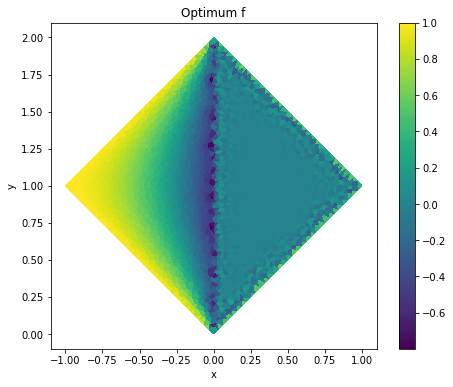

In [69]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

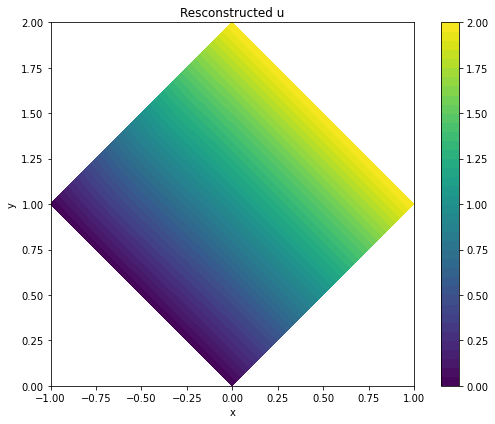

In [70]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS3.pdf")

plt.show()

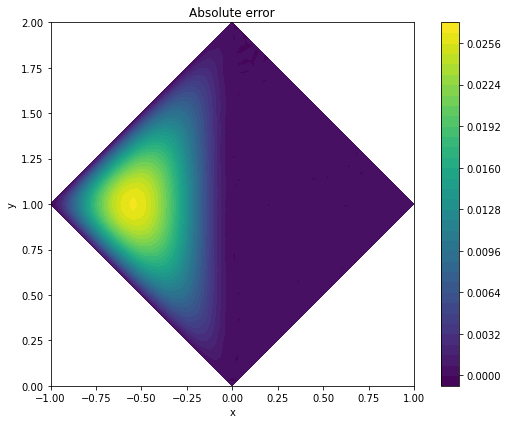

In [71]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError3.pdf")

plt.show()

#### Subdominio cuadrado

In [72]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('std::abs(x[0]) < 0.2 && std::abs(x[1]-1) < 0.2')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("0", name='Control', degree=1), W)
g = interpolate(Expression("x[0] + x[1]", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Newton CG method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 200

iteration = 0:	objective = 0.0026517321764762403:	grad_norm = 0.005215468890336482:
TEST: 2.7201115746067647e-05 1.4186657295605762e-07
cg_iter = 0	curve = 1.39586522793957e-07	hesstol = 0
-g 0.005300659999412215
iteration = 1:	objective = 1.4021767701316934e-06:	grad_norm = 8.677915355270317e-06:	delta_J = 0.0026503299997061086:
TEST: 7.530621491323634e-11 6.535009587428602e-16
cg_iter = 0	curve = 2.1016572005584437e-15	hesstol = 0
TEST: 1.3671862153071908e-11 6.535009587428602e-16
cg_iter = 1	curve = 3.751442039592168e-14	hesstol = 0
TEST: 1.0974909902602313e-11 6.535009587428602e-16
cg_iter = 2	curve = 4.292666199117965e-15	hesstol = 0
TEST: 4.651606136030183e-13 6.535009587428602e-16
cg_iter = 3	curve = 1.3032265888597495e-17	hesstol = 0
TEST: 2.1407822723244715e-13 6.535009587428602e-16
cg_iter = 4	curve = 7.31311438638968e-18	hesstol = 0
TEST: 1.0911005517558883e-12 6.5350095874

In [73]:
print(f"Time for x > 0.75: {total_time}")

Time for x > 0.75: 44.40085577964783


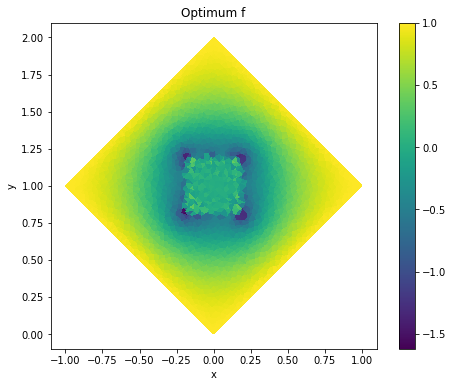

In [74]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

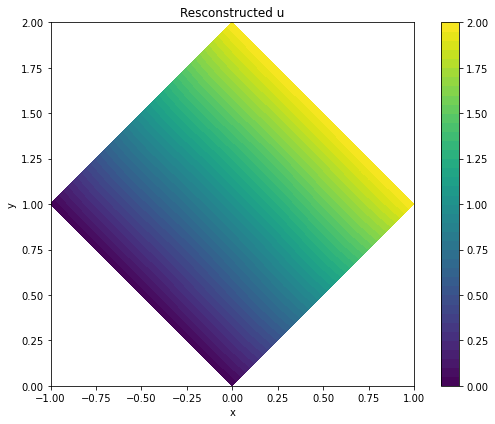

In [75]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS4.pdf")

plt.show()

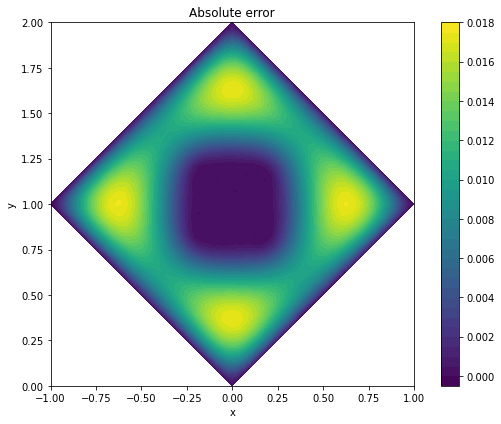

In [76]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError4.pdf")

plt.show()

### Segundo problema

Ahora se resulve el segundo problema planteado antes.

#### $x > 0.75$

In [77]:
V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("(x[0]*x[0] + x[1]*x[1])*cos(x[0]*x[1])", name='Control', degree=1), W)
g = interpolate(Expression("cos(x[0]*x[1])", degree=1), V)
u = PoissonForward(V, W, mesh, f, g)

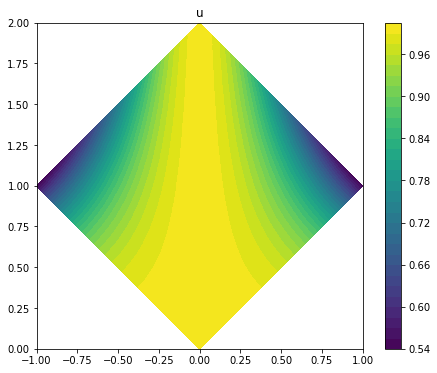

In [78]:
plt.figure(figsize=(8,6))
c = plot(u)
plt.colorbar(c)
plt.title("u")
plt.show()

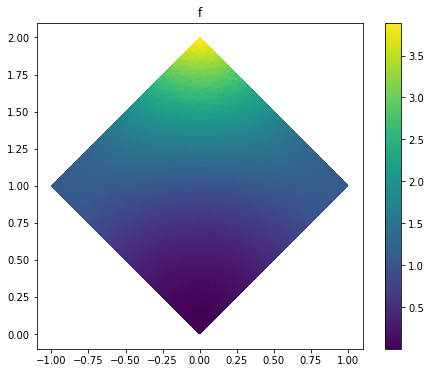

In [79]:
plt.figure(figsize=(8,6))
c = plot(f)
plt.colorbar(c)
plt.title("f")
plt.show()

In [80]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('x[0] > 0.75')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("(x[0]*x[0] + x[1]*x[1])*cos(x[0]*x[1])", name='Control', degree=1), W)
g = interpolate(Expression("cos(x[0]*x[1])", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Newton CG method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 200

iteration = 0:	objective = 2.029640824629284e-07:	grad_norm = 5.114965383211176e-06:
TEST: 2.616287087144865e-11 1.3382217883288384e-16
cg_iter = 0	curve = 1.7583560951119989e-15	hesstol = 0
TEST: 9.672686746467531e-14 1.3382217883288384e-16
cg_iter = 1	curve = 6.3325762649582435e-19	hesstol = 0
TEST: 2.16504227222537e-15 1.3382217883288384e-16
cg_iter = 2	curve = 3.431604979501676e-21	hesstol = 0
TEST: 7.845232171948242e-16 1.3382217883288384e-16
cg_iter = 3	curve = 2.3748195129370387e-21	hesstol = 0
-g 4.056813333263334e-07
iteration = 1:	objective = 1.2341579980625872e-10:	grad_norm = 9.43313438206957e-09:	delta_J = 2.0284066666312215e-07:
TEST: 8.898402427018306e-17 8.39398258797977e-25
cg_iter = 0	curve = 9.019523791244748e-23	hesstol = 0
TEST: 1.0259988952866023e-16 8.39398258797977e-25
cg_iter = 1	curve = 2.122302725399725e-22	hesstol = 0
TEST: 4.202320778630311e-17 8.393982587

In [81]:
print(f"Time for x > 0.75: {round(total_time,2)} seconds")

Time for x > 0.75: 7.63 seconds


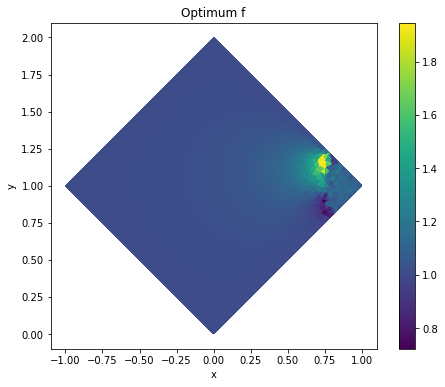

In [82]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

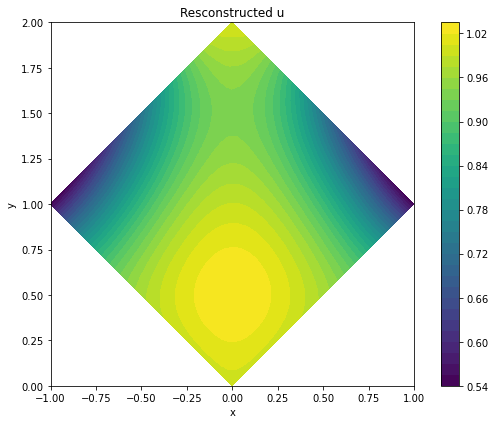

In [83]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS5.pdf")

plt.show()

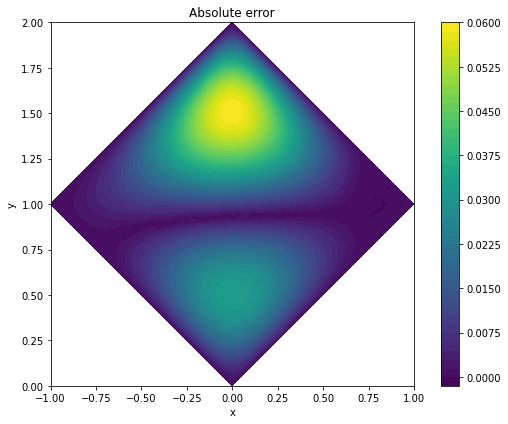

In [84]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError5.pdf")

plt.show()

#### $x > 0.5$

In [85]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('x[0] > 0.5')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("(x[0]*x[0] + x[1]*x[1])*cos(x[0]*x[1])", name='Control', degree=1), W)
g = interpolate(Expression("cos(x[0]*x[1])", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Newton CG method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 200

iteration = 0:	objective = 7.801500732191512e-06:	grad_norm = 9.88947946264654e-05:
TEST: 9.780180404210768e-09 9.672089324842052e-13
cg_iter = 0	curve = 9.198368917741924e-12	hesstol = 0
TEST: 5.786528357458535e-10 9.672089324842052e-13
cg_iter = 1	curve = 7.089362172714498e-14	hesstol = 0
TEST: 8.731708581129622e-12 9.672089324842052e-13
cg_iter = 2	curve = 1.9713812015442012e-16	hesstol = 0
TEST: 1.5421363426138909e-12 9.672089324842052e-13
cg_iter = 3	curve = 8.196668429846965e-17	hesstol = 0
-g 1.553767454009228e-05
iteration = 1:	objective = 3.266346214436843e-08:	grad_norm = 6.646686323812042e-07:	delta_J = 7.768837270047143e-06:
TEST: 4.417843908715004e-13 2.936402268879235e-19
cg_iter = 0	curve = 1.2011231989156166e-17	hesstol = 0
TEST: 5.245095706435079e-13 2.936402268879235e-19
cg_iter = 1	curve = 1.1629542497065579e-17	hesstol = 0
TEST: 1.8467007015183965e-13 2.93640226887

In [86]:
print(f"Time for x > 0.5: {round(total_time,2)} seconds")

Time for x > 0.5: 49.25 seconds


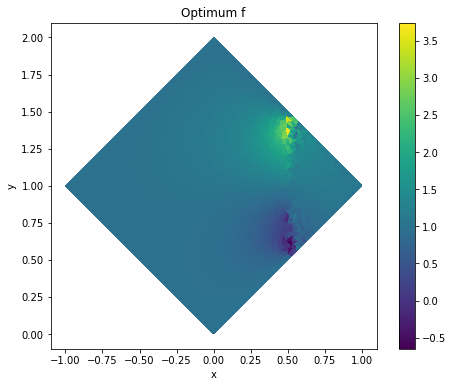

In [87]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

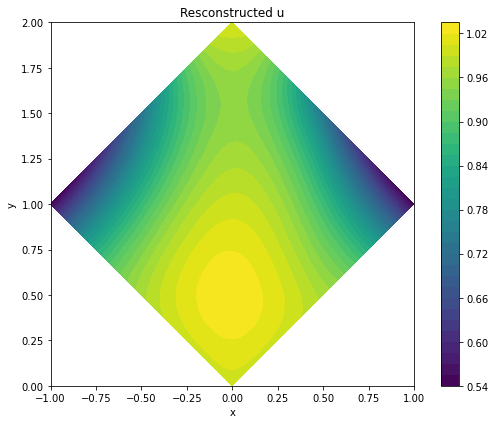

In [88]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS6.pdf")

plt.show()

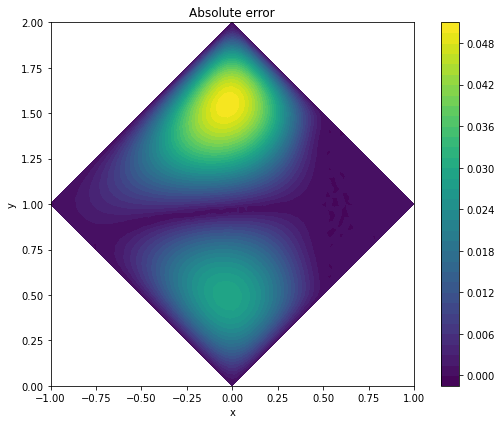

In [89]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError6.pdf")

plt.show()

#### $x > 0$

In [90]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('x[0] > 0.')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("(x[0]*x[0] + x[1]*x[1])*cos(x[0]*x[1])", name='Control', degree=1), W)
g = interpolate(Expression("cos(x[0]*x[1])", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Se han truncado las últimas 5000 líneas del flujo de salida.
cg_iter = 114	curve = 3.8291613522763275e-21	hesstol = 0
TEST: 2.9667037603379777e-21 3.6957550847781713e-28
cg_iter = 115	curve = 7.065393218735908e-25	hesstol = 0
TEST: 2.1859443197359706e-21 3.6957550847781713e-28
cg_iter = 116	curve = 5.032608428853603e-25	hesstol = 0
TEST: 7.579785205891331e-21 3.6957550847781713e-28
cg_iter = 117	curve = 1.7295170988086842e-25	hesstol = 0
TEST: 9.948481408048586e-21 3.6957550847781713e-28
cg_iter = 118	curve = 9.913230174895021e-24	hesstol = 0
TEST: 7.557793154481078e-21 3.6957550847781713e-28
cg_iter = 119	curve = 6.495831749971204e-25	hesstol = 0
TEST: 2.9939243412201517e-20 3.6957550847781713e-28
cg_iter = 120	curve = 4.320154257560571e-24	hesstol = 0
TEST: 2.029351411337627e-21 3.6957550847781713e-28
cg_iter = 121	curve = 2.0096174030539948e-26	hesstol = 0
TEST: 2.569404464792298e-19 3.6957550847781713e-28
cg_iter = 122	curve = 2.3715317019081077e-21	hesstol = 0
TEST: 1.271985930581

In [91]:
print(f"Time for x > 0.: {total_time}")

Time for x > 0.: 382.3738691806793


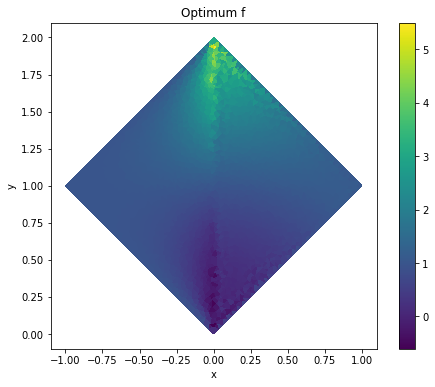

In [92]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

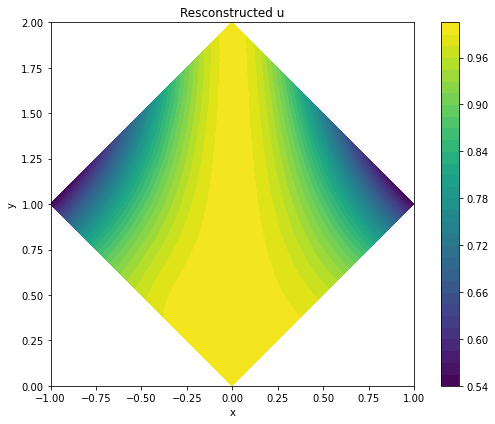

In [93]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS7.pdf")

plt.show()

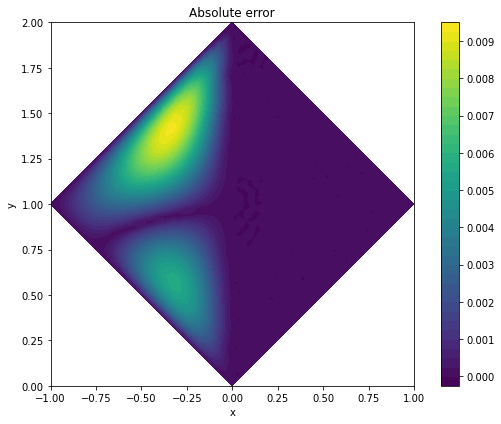

In [94]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError7.pdf")

plt.show()

#### Subdominio cuadrado

In [95]:
mesh = dol_ad.Mesh(mshr.generate_mesh(p, 30))
domains = MeshFunction("size_t", mesh, mesh.topology().dim())
subdomain = CompiledSubDomain('std::abs(x[0]) < 0.1 && std::abs(x[1]-1) < 0.1')
subdomain.mark(domains, True)

domains.set_all(0)
subdomain.mark(domains, 1)
dx = Measure('dx', domain=mesh, subdomain_data=domains)

V = FunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, "DG", 0)
f = interpolate(Expression("(x[0]*x[0] + x[1]*x[1])*cos(x[0]*x[1])", name='Control', degree=1), W)
g = interpolate(Expression("cos(x[0]*x[1])", degree=1), V)
u_meas = PoissonForward(V, W, mesh, f, g)

f_ctrl = interpolate(Expression("1", degree = 1), W) 
u_ctrl = PoissonForward(V, W, mesh, f_ctrl, g)

alpha = Constant(1e-12)
J1 = ((u_meas - u_ctrl)**2) * dx(1)
J2 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(0)
J3 = alpha * inner(grad(f_ctrl), grad(f_ctrl)) * dx(1)
J = assemble(J1 + J2 + J3)
control = Control(f_ctrl)

initial_time = time()

rf = ReducedFunctional(J, control)

problem = dol_ad.MoolaOptimizationProblem(rf)
f_moola = moola.DolfinPrimalVector(f_ctrl)
solver = moola.NewtonCG(problem, f_moola, options={'gtol': 1e-12,
                                                   'maxiter': 200,
                                                   'display': 3,
                                                   'ncg_hesstol': 0})

sol = solver.solve()
f_opt = sol['control'].data

total_time = time() - initial_time

Newton CG method.
------------------------------
Line search:		 strong_wolfe
Maximum iterations:	 200

iteration = 0:	objective = 6.6657143277024025e-06:	grad_norm = 0.00011394355631458011:
TEST: 1.2983134025613888e-08 1.4793444629872772e-12
cg_iter = 0	curve = 1.534452915571267e-11	hesstol = 0
TEST: 3.903673844700939e-11 1.4793444629872772e-12
cg_iter = 1	curve = 6.516780712667886e-16	hesstol = 0
-g 1.3323511753978928e-05
iteration = 1:	objective = 3.958450713069781e-09:	grad_norm = 6.52893880303606e-08:	delta_J = 6.661755876989333e-06:
TEST: 4.262704189378994e-15 2.783093478790089e-22
cg_iter = 0	curve = 1.5628351558236065e-20	hesstol = 0
TEST: 1.2110044688507161e-14 2.783093478790089e-22
cg_iter = 1	curve = 4.3910623136073266e-20	hesstol = 0
TEST: 4.498563053909993e-15 2.783093478790089e-22
cg_iter = 2	curve = 3.677614551831936e-18	hesstol = 0
TEST: 2.0183680460780814e-15 2.783093478790089e-22
cg_iter = 3	curve = 1.6494663210099953e-21	hesstol = 0
TEST: 3.6862839605030705e-15 2.7830

In [96]:
print(f"Time for square subdomain: {total_time}")

Time for square subdomain: 17.01561403274536


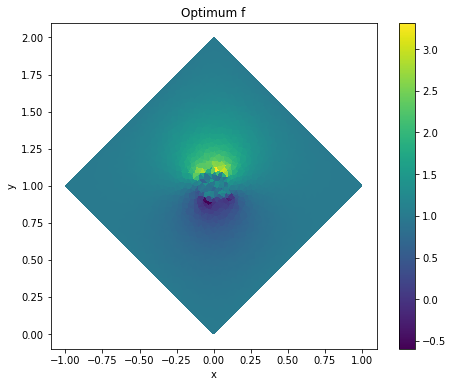

In [97]:
plt.figure(figsize=(8,6))
c = plot(f_opt, title="Optimum f")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

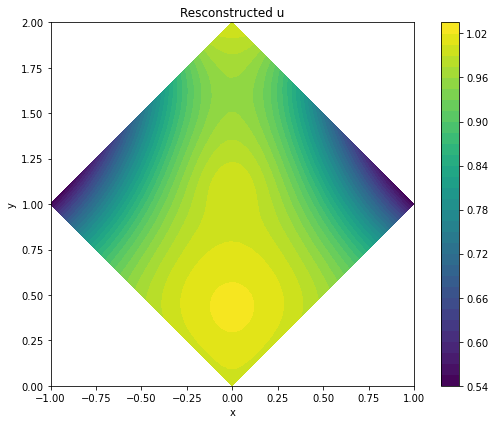

In [98]:
u_opt = PoissonForward(V, W, mesh, f_opt, g)
plt.figure(figsize=(8,6))
c = plot(u_opt, title="Resconstructed u")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCS8.pdf")

plt.show()

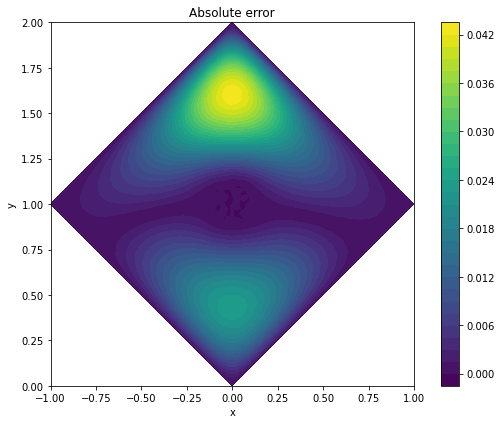

In [99]:
error = abs(u_meas - u_opt)
plt.figure(figsize=(8,6))
c = plot(error, title="Absolute error")
plt.colorbar(c)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()

plt.savefig("UCPFEniCSError8.pdf")

plt.show()